In [1]:
#importing libraries 
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy
from scipy.stats import chisquare
from bioinfokit.analys import stat
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from scipy.stats import chi2_contingency
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix 
from sklearn.svm import SVC
#from sklearn.xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score 

from xgboost import XGBClassifier


%matplotlib inline 

pd.set_option('display.max_colwidth', None) #to display all columns in the dataframe
pd.set_option('display.max_columns', None )
# to display all columns and rows:
pd.set_option('display.max_columns', None); 
pd.set_option('display.max_rows', None);

import matplotlib.style as style

style.use('fivethirtyeight')


In [2]:
#loading data 
df = pd.read_excel("ILLINOIS DATA.xlsx")
df.tail() 

,YEAR,CASEID,STATE,CBSA2010,LEVEL OF EDUCATION,MARITAL STATUS,TYPE OF SERVICES,Detailed criminal justice referral,Previous substance use treatment episodes,REFERRAL SOURCE,ARRESTS,Employment status,Medication-assisted opioid therapy,Co-occurring mental and substance use disorders,Pregnant at admission,GENDER,VETERAN STATUS,RACE
36206,2020,885737,ILLINOIS,34980.00,Grade 12 (or GED),Never Married,"Rehab/residential, short term (30 days or fewer)",STATE/FEDERAL COURT,Two prior treatment episodes,Court/criminal justice referral/DUI/DWI,None,Not in Labour Force,No,Yes,Yes,FEMALE,NO,Black or African American
36207,2020,928137,ILLINOIS,20580.00,Grades 9 to 11,Never Married,"Ambulatory, non-intensive outpatient",NaN,One prior treatment episode,Other community referral,None,Unemployed,No,NaN,Yes,FEMALE,NO,White
36208,2020,1241474,ILLINOIS,36260.00,Grade 12 (or GED),Never Married,"Ambulatory, non-intensive outpatient",NaN,Four prior treatment episodes,Individual (includes self-referral),None,Unemployed,No,Yes,Yes,FEMALE,NO,Other single race
36209,2020,1031418,ILLINOIS,47260.00,"1-3 years of college, university, or vocational school",NaN,"Ambulatory, non-intensive outpatient",NaN,One prior treatment episode,NaN,None,Unemployed,No,NaN,Yes,FEMALE,NaN,White
36210,2020,613826,ILLINOIS,30100.00,"1-3 years of college, university, or vocational school",NaN,"Detox, 2Rehab/residential, short term-hour, free-standing residential",NaN,Two prior treatment episodes,Individual (includes self-referral),None,Unemployed,No,NaN,NaN,MALE,NaN,Black or African American


In [3]:
#concise summary of the data 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36211 entries, 0 to 36210
Data columns (total 18 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   YEAR                                             36211 non-null  int64  
 1   CASEID                                           36211 non-null  int64  
 2   STATE                                            36211 non-null  object 
 3   CBSA2010                                         31218 non-null  float64
 4   LEVEL OF EDUCATION                               36207 non-null  object 
 5   MARITAL STATUS                                   36183 non-null  object 
 6   TYPE OF SERVICES                                 36211 non-null  object 
 7   Detailed criminal justice referral               13214 non-null  object 
 8   Previous substance use treatment episodes        36201 non-null  object 
 9   REFERRAL SOURCE             

**Dealing with Missing Values**

In [4]:
# Calculate the number and percentage of missing values for all columns
missing_values_count = df.isnull().sum()
missing_values_pct = round((missing_values_count / len(df)) * 100, 2)

# Creating a new DataFrame with the results
result_df = pd.DataFrame({
    'Num Missing Values': missing_values_count,
    'Pct Missing Values': missing_values_pct
})

# Display the results
result_df

,Num Missing Values,Pct Missing Values
YEAR,0,0.00
CASEID,0,0.00
STATE,0,0.00
CBSA2010,4993,13.79
LEVEL OF EDUCATION,4,0.01
MARITAL STATUS,28,0.08
TYPE OF SERVICES,0,0.00
Detailed criminal justice referral,22997,63.51
Previous substance use treatment episodes,10,0.03
REFERRAL SOURCE,5,0.01


In [5]:
def categorical_var(data, var):
    results = data[var].value_counts()
    return results
    

In [6]:
# Convert specified columns to the category data type
columns_to_convert = ['LEVEL OF EDUCATION', 'Previous substance use treatment episodes', 'REFERRAL SOURCE', 'MARITAL STATUS',
                      'ARRESTS', 'Employment status', 'Medication-assisted opioid therapy', 'GENDER', 'RACE', 'TYPE OF SERVICES',
                      'Co-occurring mental and substance use disorders', 'VETERAN STATUS']

df[columns_to_convert] = df[columns_to_convert].astype('category')

# Replace missing values in each column with the mode
for column in columns_to_convert:
    mode_value = df[column].mode().iloc[0]
    df[column].fillna(mode_value, inplace=True)


In [7]:
columns_to_drop = ['Detailed criminal justice referral', 'Pregnant at admission', 'CBSA2010']

# drop columns we dont need 
df.drop(columns=columns_to_drop, inplace=True)

In [8]:
# checking if our changes has been effected
missing_values_count = df.isnull().sum()
missing_values_pct = round((missing_values_count / len(df)) * 100, 2)

# Create a new DataFrame with the results
result_df = pd.DataFrame({
    'Num Missing Values': missing_values_count,
    'Pct Missing Values': missing_values_pct
})

# Display the results
result_df

,Num Missing Values,Pct Missing Values
YEAR,0,0.00
CASEID,0,0.00
STATE,0,0.00
LEVEL OF EDUCATION,0,0.00
MARITAL STATUS,0,0.00
TYPE OF SERVICES,0,0.00
Previous substance use treatment episodes,0,0.00
REFERRAL SOURCE,0,0.00
ARRESTS,0,0.00
Employment status,0,0.00


In [9]:
#saving the cleaned data back to excel format
file_path = 'illinois_cleaned_data.xlsx'

df.to_excel(file_path, index=False)  

print(f'DataFrame saved to {file_path}')


DataFrame saved to illinois_cleaned_data.xlsx


- Converted object data types to categorical variables for columns such as 'LEVEL OF EDUCATION,' 'Previous substance use treatment episodes,' 'REFERRAL SOURCE,' 'ARRESTS,' 'Employment status,' 'Medication-assisted opioid therapy,' 'Co-occurring mental and substance use disorders,', 'MARITAL STATUS', and 'VETERAN STATUS.'

- Replaced missing values in these categorical columns with the mode to ensure data completeness.

- Dropped unnecessary columns (columnd ith over 60% missing values), including 'Detailed criminal justice referral' and 'Pregnant at admission.'

- The cleaned dataset was saved to an Excel file named 'cleaned_data.xlsx' for further analysis."

In [10]:
#descriptive statistics of variables 
df.describe(include = 'category')

,LEVEL OF EDUCATION,MARITAL STATUS,TYPE OF SERVICES,Previous substance use treatment episodes,REFERRAL SOURCE,ARRESTS,Employment status,Medication-assisted opioid therapy,Co-occurring mental and substance use disorders,GENDER,VETERAN STATUS,RACE
count,36211,36211,36211,36211,36211,36211,36211,36211,36211,36211,36211,36211
unique,5,4,5,6,7,3,4,2,2,2,2,8
top,Grade 12 (or GED),Never Married,"Ambulatory, non-intensive outpatient",No prior treatment episodes,Individual (includes self-referral),None,Unemployed,No,No,MALE,NO,White
freq,17621,24615,19990,16783,16644,34450,18508,34902,30333,24111,35201,20909


**Univariate Analysis**

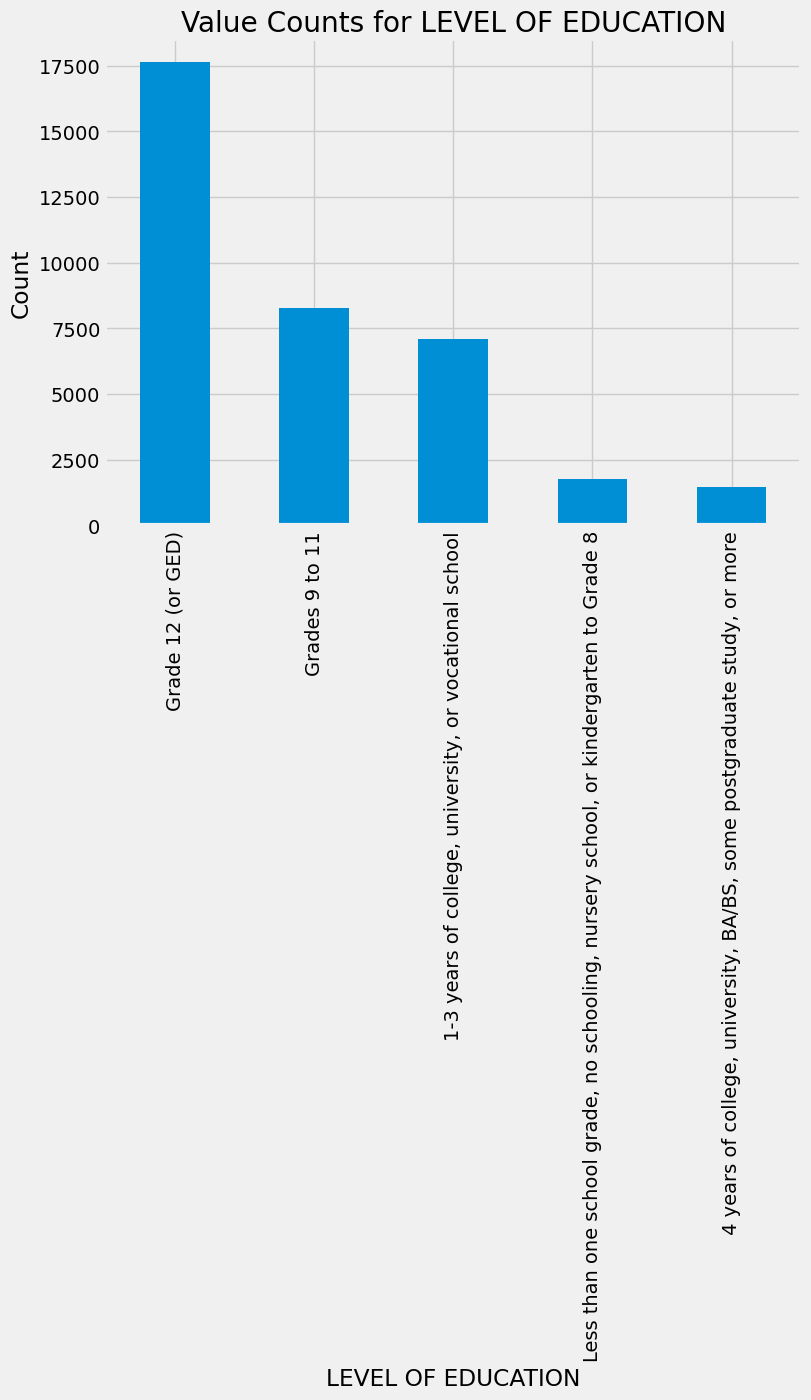

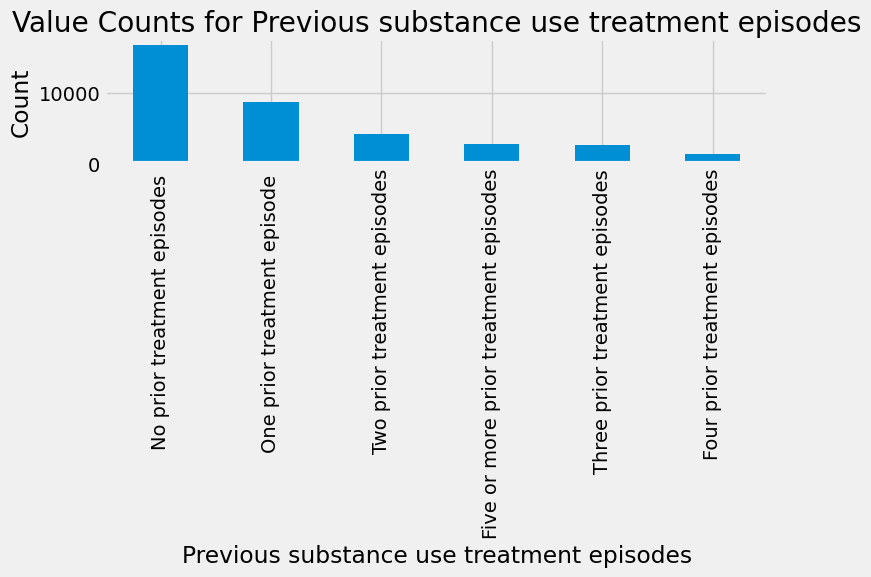

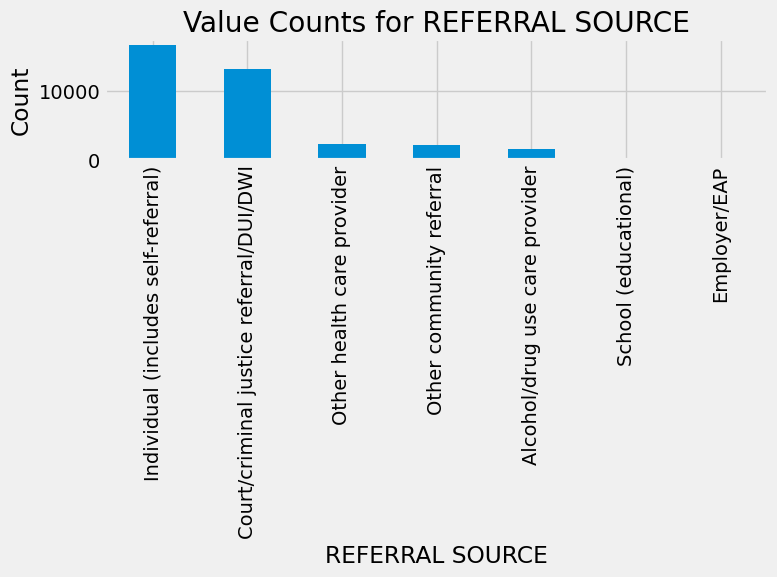

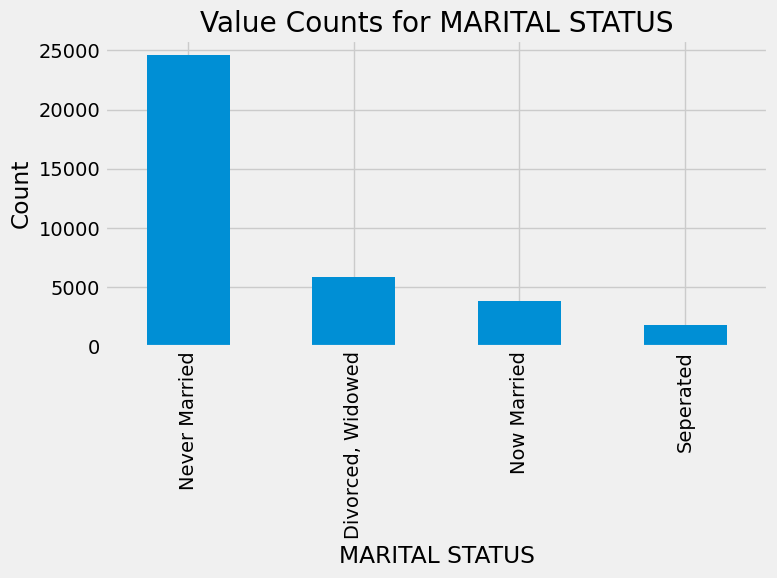

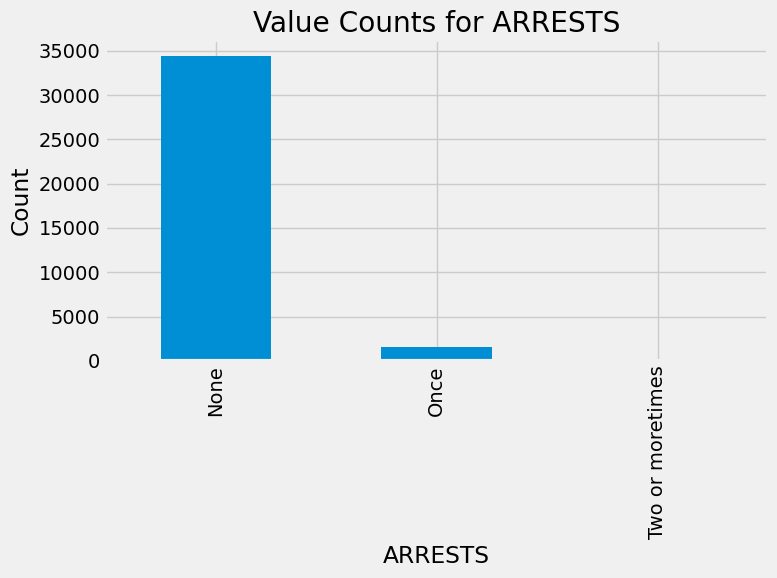

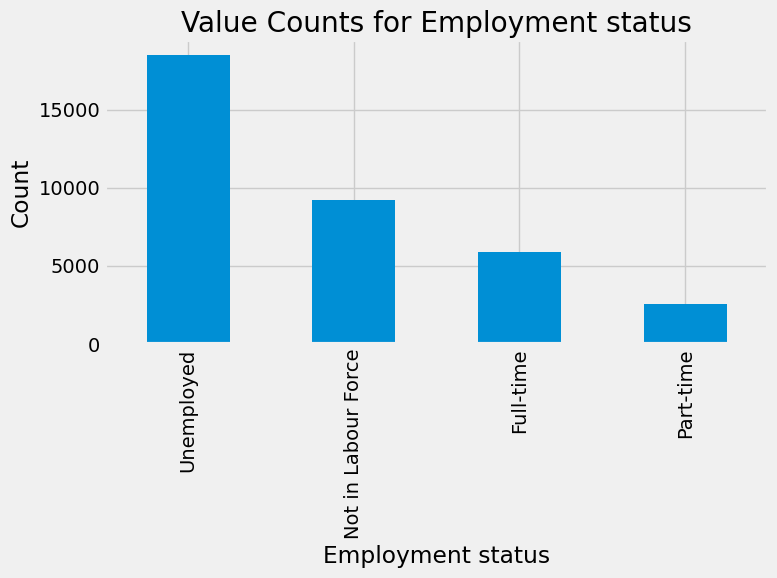

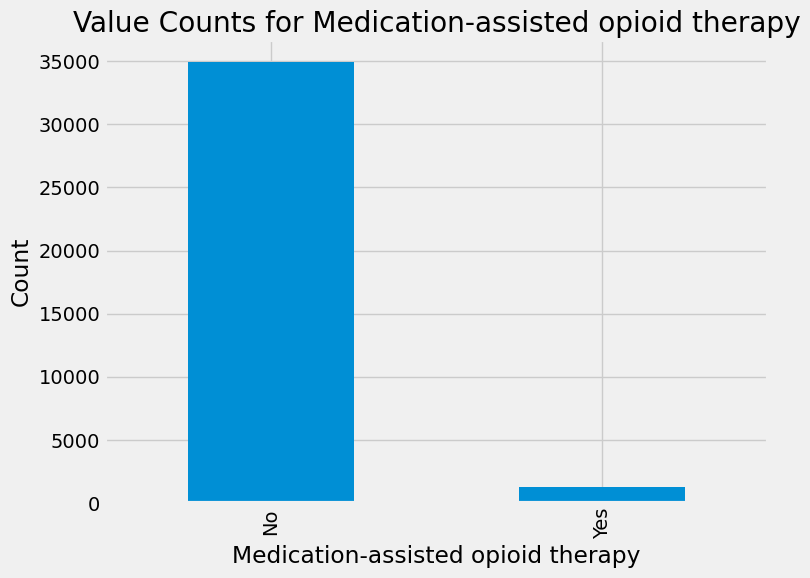

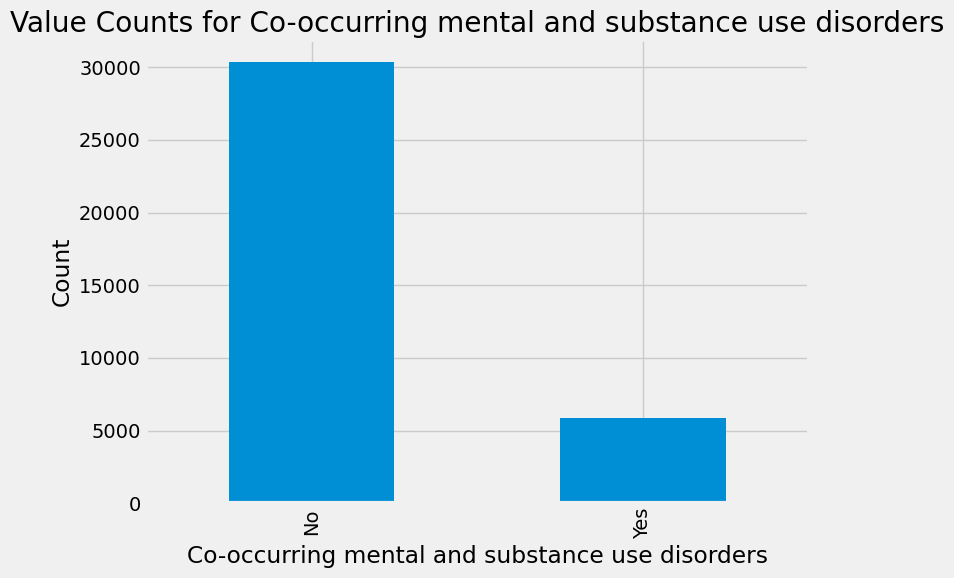

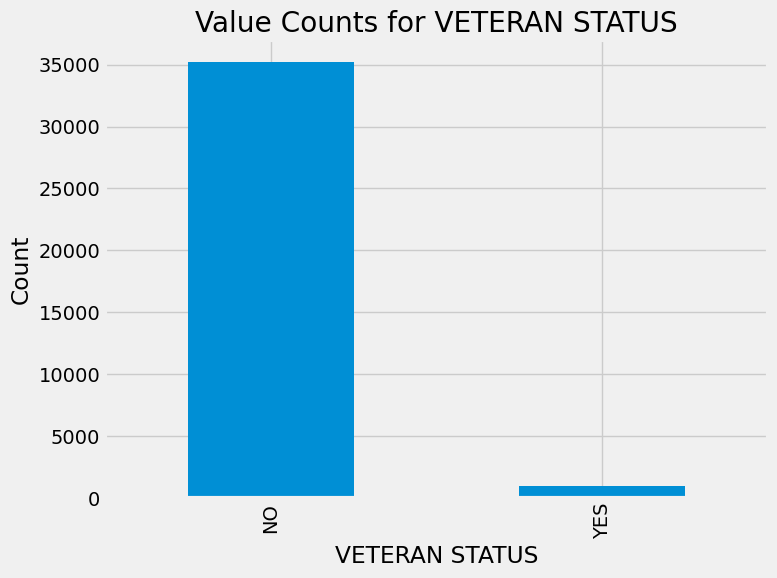

In [11]:
#value counts for the categorical variables 
variables_to_plot = ['LEVEL OF EDUCATION', 'Previous substance use treatment episodes',
                     'REFERRAL SOURCE', 'MARITAL STATUS', 'ARRESTS',
                     'Employment status', 'Medication-assisted opioid therapy',
                     'Co-occurring mental and substance use disorders', 'VETERAN STATUS']

# Loop through the selected variables and create value count plots
for var in variables_to_plot:
    # Get value counts for the variable
    value_counts = df[var].value_counts()
    
    # Create a bar plot
    plt.figure(figsize=(8, 6))
    value_counts.plot(kind='bar')
    
    # Set plot labels and title
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.title(f'Value Counts for {var}')
    
    # Show the plot
    plt.tight_layout()
    plt.show()


In [12]:
categorical=df.select_dtypes(include=['category'])
for cat in categorical:
    print(cat)

LEVEL OF EDUCATION
MARITAL STATUS
TYPE OF SERVICES
Previous substance use treatment episodes
REFERRAL SOURCE
ARRESTS
Employment status
Medication-assisted opioid therapy
Co-occurring mental and substance use disorders
GENDER
VETERAN STATUS
RACE


### Statistical Tests - Chi Square Test

It is crucial to understand the relationships between various factors, especially when dealing with categorical data. In this context, we aim to investigate how different independent categorical variables relate to a critical dependent variable known as "Co-occurring mental and substance use disorders." To do this, we employ the Chi-Square test, a statistical method that helps us determine if there is a significant association between the variables.

**Hypotheses**

- **Null Hypothesis (H0):** There is no significant association between the independent categorical variable and Co-occurring mental and substance use disorders.
- **Alternative Hypothesis (H1):** There is a significant association between the independent categorical variable and Co-occurring mental and substance use disorders.

In [13]:
def chi_square_test(data, independent_var, dependent_var):
    # Creating a contingency table
    contingency_table = pd.crosstab(data[independent_var], data[dependent_var])
    
    print(contingency_table)

    pd.crosstab(data[independent_var], data[dependent_var]).plot.bar()
    
    # Perform the chi-square test
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    # Define the significance level (alpha)
    alpha = 0.05
    
    # Determine whether to reject or fail to reject the null hypothesis
    if p < alpha:
        result = "Reject the null hypothesis (There is a significant relationship)"
    else:
        result = "Fail to reject the null hypothesis (There is no significant relationship)"
    
    return chi2, p, result


Co-occurring mental and substance use disorders     No   Yes
RACE                                                        
-Native Hawaiian or Other Pacific Islander           4     2
Alaska Native (Aleut, Eskimo, Indian)               14     3
American Indian (other than Alaska Native)          88    23
Asian                                              114    16
Black or African American                         9423  1360
Native Hawaiian or Other Pacific Islander           43     6
Other single race                                 3651   555
White                                            16996  3913
Chi-square Statistic: 232.1793120228889
P-value: 1.7087662753791598e-46
Reject the null hypothesis (There is a significant relationship)


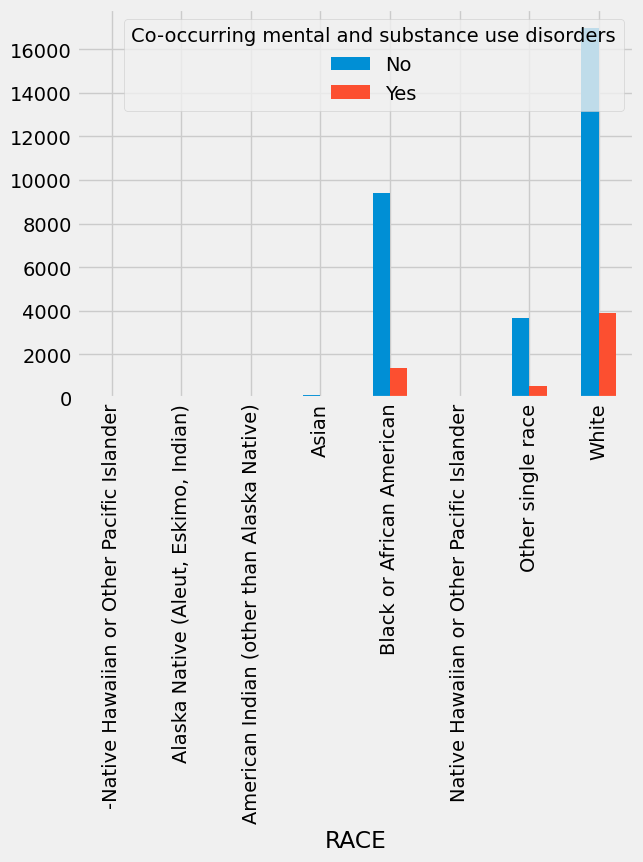

In [14]:
chi2_statistic, p_value, result = chi_square_test(df, 'RACE','Co-occurring mental and substance use disorders')
print(f"Chi-square Statistic: {chi2_statistic}")
print(f"P-value: {p_value}")
print(result)

Co-occurring mental and substance use disorders     No   Yes
MARITAL STATUS                                              
Divorced, Widowed                                 4818  1074
Never Married                                    20707  3908
Now Married                                       3304   585
Seperated                                         1504   311
Chi-square Statistic: 24.688353168496512
P-value: 1.7939369683759457e-05
Reject the null hypothesis (There is a significant relationship)


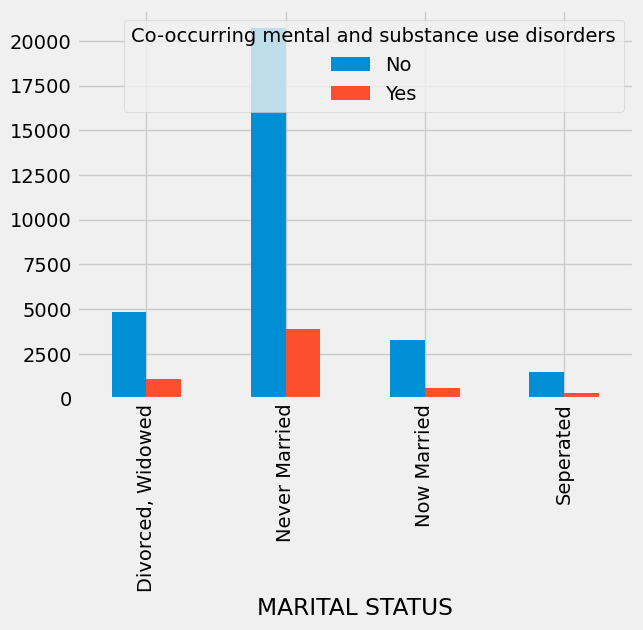

In [15]:
chi2_statistic, p_value, result = chi_square_test(df, 'MARITAL STATUS','Co-occurring mental and substance use disorders')
print(f"Chi-square Statistic: {chi2_statistic}")
print(f"P-value: {p_value}")
print(result)

Co-occurring mental and substance use disorders     No   Yes
GENDER                                                      
FEMALE                                            9506  2594
MALE                                             20827  3284
Chi-square Statistic: 361.5445729845437
P-value: 1.2979549190435714e-80
Reject the null hypothesis (There is a significant relationship)


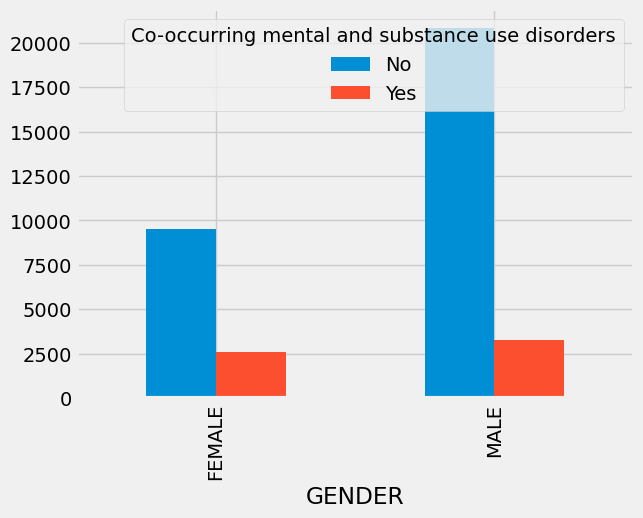

In [16]:
chi2_statistic, p_value, result = chi_square_test(df, 'GENDER','Co-occurring mental and substance use disorders')
print(f"Chi-square Statistic: {chi2_statistic}")
print(f"P-value: {p_value}")
print(result)

Co-occurring mental and substance use disorders     No   Yes
VETERAN STATUS                                              
NO                                               29481  5720
YES                                                852   158
Chi-square Statistic: 0.2224508343391775
P-value: 0.6371788172932837
Fail to reject the null hypothesis (There is no significant relationship)


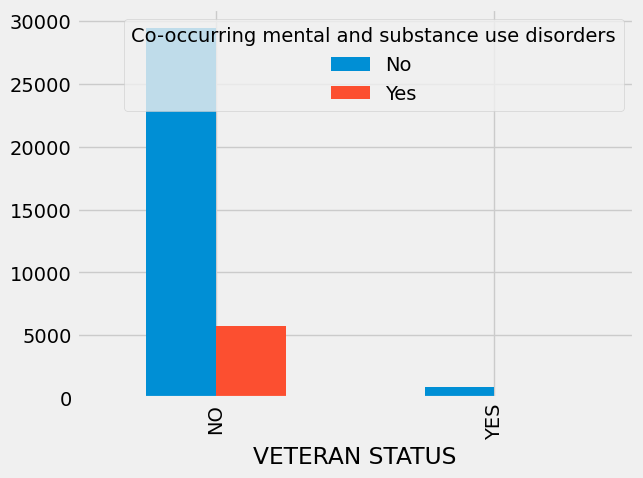

In [17]:
chi2_statistic, p_value, result = chi_square_test(df, 'VETERAN STATUS','Co-occurring mental and substance use disorders')
print(f"Chi-square Statistic: {chi2_statistic}")
print(f"P-value: {p_value}")
print(result)

Co-occurring mental and substance use disorders     No   Yes
Previous substance use treatment episodes                   
Five or more prior treatment episodes             1888   793
Four prior treatment episodes                      998   345
No prior treatment episodes                      15068  1715
One prior treatment episode                       7063  1574
Three prior treatment episodes                    1986   588
Two prior treatment episodes                      3330   863
Chi-square Statistic: 1052.1514711197797
P-value: 3.071743192895596e-225
Reject the null hypothesis (There is a significant relationship)


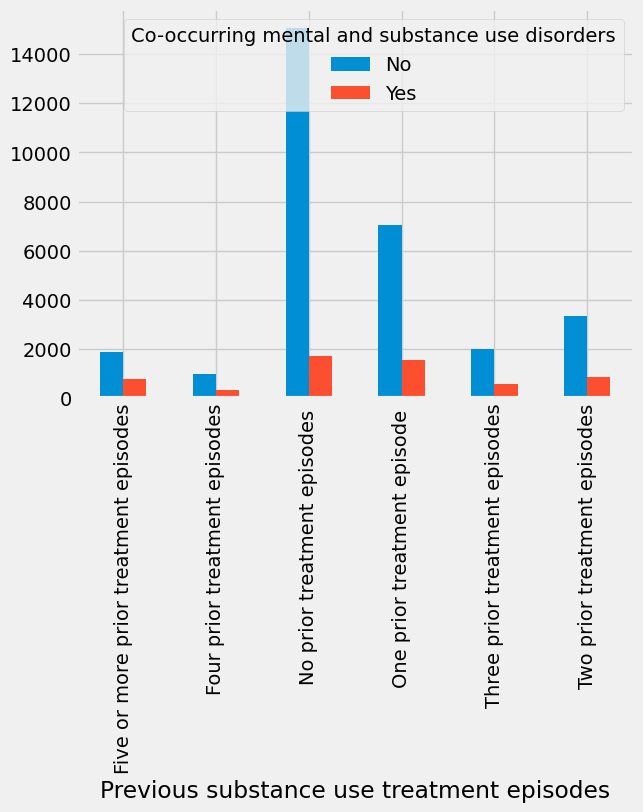

In [18]:
chi2_statistic, p_value, result = chi_square_test(df, 'Previous substance use treatment episodes','Co-occurring mental and substance use disorders')
print(f"Chi-square Statistic: {chi2_statistic}")
print(f"P-value: {p_value}")
print(result)

Co-occurring mental and substance use disorders     No   Yes
RACE                                                        
-Native Hawaiian or Other Pacific Islander           4     2
Alaska Native (Aleut, Eskimo, Indian)               14     3
American Indian (other than Alaska Native)          88    23
Asian                                              114    16
Black or African American                         9423  1360
Native Hawaiian or Other Pacific Islander           43     6
Other single race                                 3651   555
White                                            16996  3913
Chi-square Statistic: 232.1793120228889
P-value: 1.7087662753791598e-46
Reject the null hypothesis (There is a significant relationship)


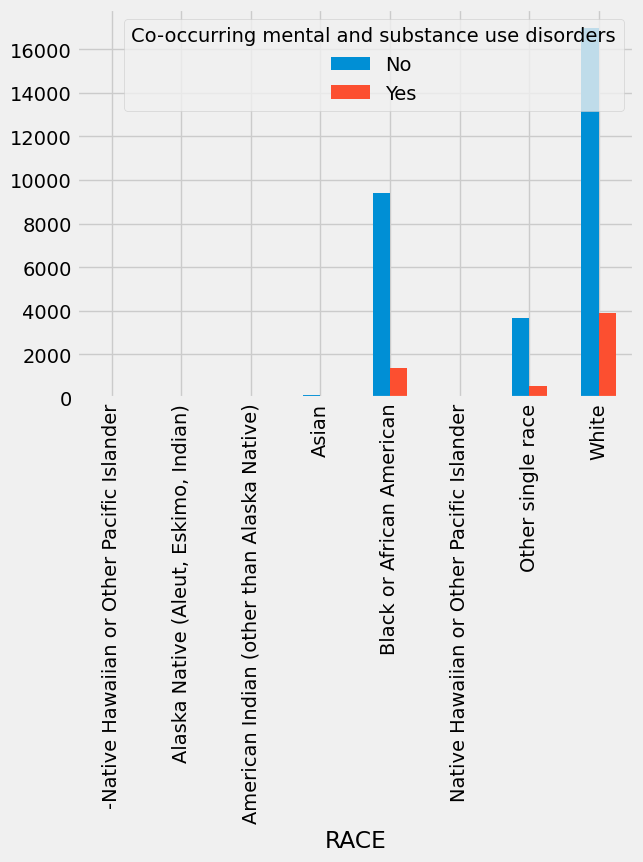

In [19]:
chi2_statistic, p_value, result = chi_square_test(df, 'RACE','Co-occurring mental and substance use disorders')
print(f"Chi-square Statistic: {chi2_statistic}")
print(f"P-value: {p_value}")
print(result)

Co-occurring mental and substance use disorders                                          No  \
LEVEL OF EDUCATION                                                                            
 4 years of college, university, BA/BS, some postgraduate study, or more               1106   
1-3 years of college, university, or vocational school                                 5703   
Grade 12 (or GED)                                                                     14917   
Grades 9 to 11                                                                         7045   
Less than one school grade, no schooling, nursery school, or kindergarten to Grade 8   1562   

Co-occurring mental and substance use disorders                                        Yes  
LEVEL OF EDUCATION                                                                          
 4 years of college, university, BA/BS, some postgraduate study, or more               355  
1-3 years of college, university, or vocational school 

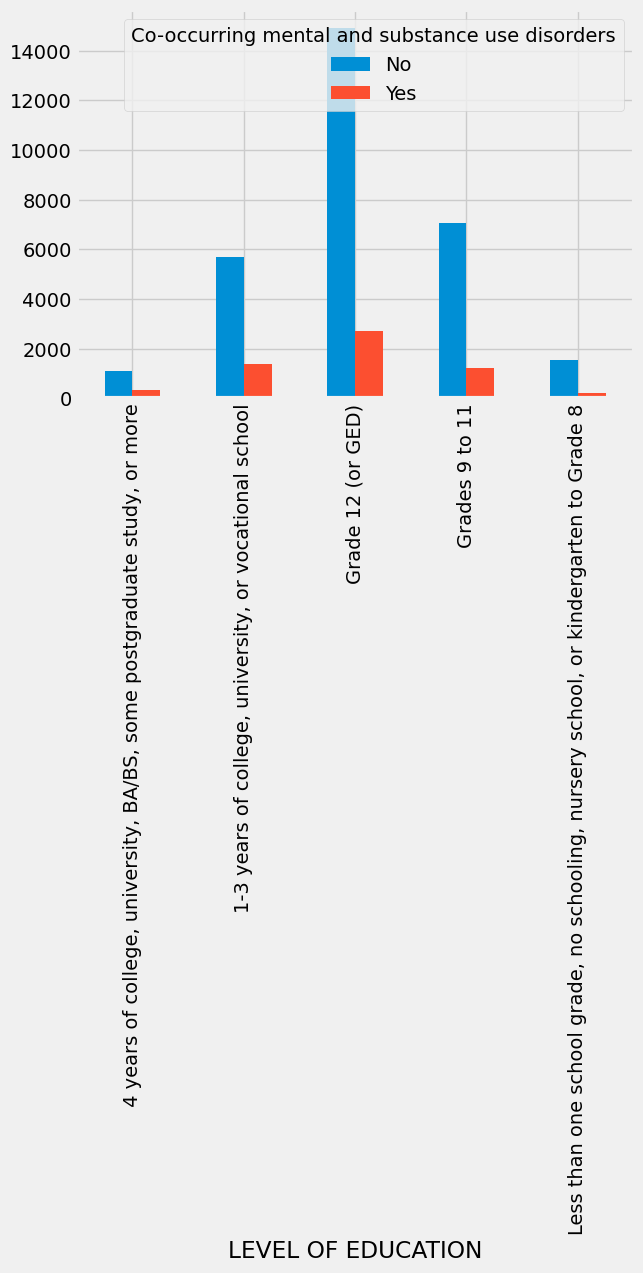

In [20]:
chi2_statistic, p_value, result = chi_square_test(df, 'LEVEL OF EDUCATION','Co-occurring mental and substance use disorders')
print(f"Chi-square Statistic: {chi2_statistic}")
print(f"P-value: {p_value}")
print(result)

Co-occurring mental and substance use disorders     No   Yes
ARRESTS                                                     
None                                             28960  5490
Once                                              1251   353
Two or moretimes                                   122    35
Chi-square Statistic: 45.80668258023977
P-value: 1.1303300162000342e-10
Reject the null hypothesis (There is a significant relationship)


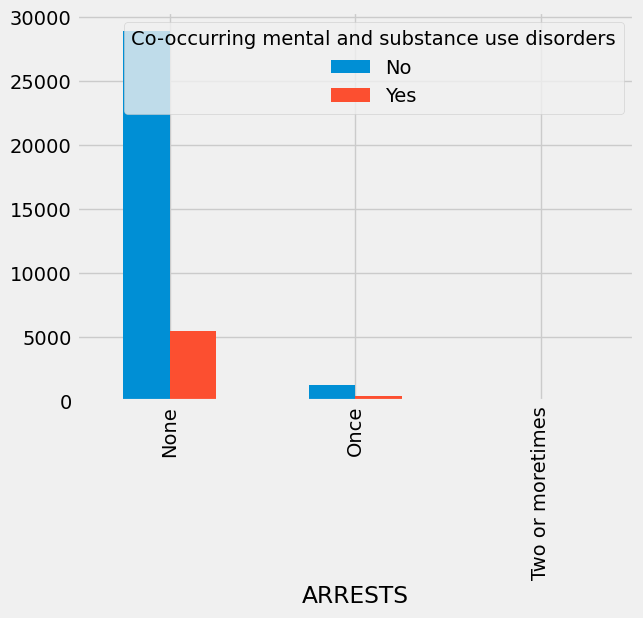

In [21]:
chi2_statistic, p_value, result = chi_square_test(df, 'ARRESTS','Co-occurring mental and substance use disorders')
print(f"Chi-square Statistic: {chi2_statistic}")
print(f"P-value: {p_value}")
print(result)

Co-occurring mental and substance use disorders     No   Yes
Medication-assisted opioid therapy                          
No                                               29148  5754
Yes                                               1185   124
Chi-square Statistic: 45.1238362041013
P-value: 1.8496036216030382e-11
Reject the null hypothesis (There is a significant relationship)


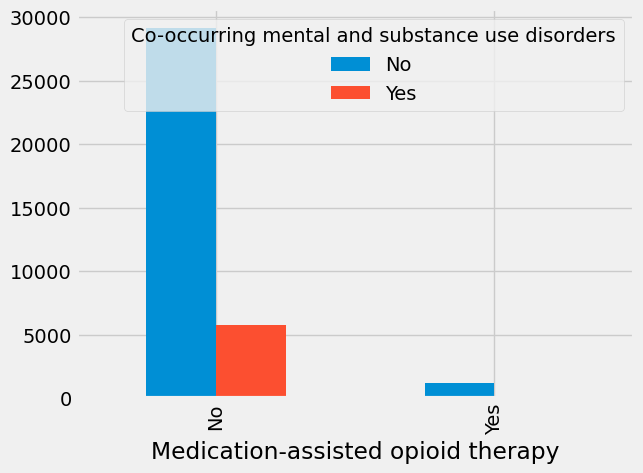

In [22]:
chi2_statistic, p_value, result = chi_square_test(df, 'Medication-assisted opioid therapy','Co-occurring mental and substance use disorders')
print(f"Chi-square Statistic: {chi2_statistic}")
print(f"P-value: {p_value}")
print(result)

**explanation and interpretation of the results:**

We performed chi-square tests to examine the relationship between various independent variables and the dependent variable 'Co-occurring mental and substance use disorders,' which represents substance abuse. We used a significance level (alpha) of 0.05 to determine statistical significance.

Statistically Significant Variables:

- Race: The chi-square test indicates that there is a statistically significant relationship between the race of individuals and their likelihood of experiencing co-occurring mental and substance use disorders (substance abuse). This means that race is associated with differences in the occurrence of substance abuse.

- Marital Status: The chi-square test shows a statistically significant relationship between marital status and the presence of co-occurring mental and substance use disorders. Marital status is a factor that influences the likelihood of experiencing substance abuse.

- Previous Substance Use Treatment Episodes: Our analysis reveals a statistically significant relationship between the number of previous substance use treatment episodes and the occurrence of co-occurring mental and substance use disorders. This implies that individuals with different treatment histories have varying rates of substance abuse.

- LEVEL OF EDUCATION: The chi-square test demonstrates statistical significance between the level of education and co-occurring mental and substance use disorders. Education level is a factor that influences the likelihood of experiencing substance abuse.

- Medication-assisted Opioid Therapy: Our analysis indicates a statistically significant relationship between the use of medication-assisted opioid therapy and co-occurring mental and substance use disorders. This suggests that this therapy may be associated with differences in the occurrence of substance abuse.

**Non-Statistically Significant Variable:**

- VETERAN STATUS: The chi-square test did not find a statistically significant relationship between veteran status and co-occurring mental and substance use disorders. In statistical terms, this means that veteran status is not associated with differences in the occurrence of substance abuse among individuals in our dataset.

Statistical significance suggests that there is evidence to conclude that the mentioned independent variables are associated with differences in the occurrence of co-occurring mental and substance use disorders (substance abuse). In practical terms, this means that these variables are relevant when considering the likelihood of substance abuse among individuals.

**Data Preprocessing**

We use one-hot encoding and label encoding during preprocessing to convert categorical variables into a numerical format that machine learning models can understand:

One-Hot Encoding: is used when categorical variables have no inherent order. Each category is converted into a binary column, representing its presence or absence. This ensures that the model doesn't misinterpret categorical data as having meaningful ordinal relationships.

Label Encoding is used when categorical variables exhibit a clear ordinal relationship, meaning there's a logical order among categories. Label encoding assigns a unique numerical label to each category based on their order, making it easier for models to capture this ordinality.



In [24]:
# List of variables to be one-hot encoded
one_hot_vars = ['Previous substance use treatment episodes', 'MARITAL STATUS', 'ARRESTS', 'GENDER', 
                'Medication-assisted opioid therapy', 'Employment status', 'RACE']

# Perform one-hot encoding for selected variables
df = pd.get_dummies(df, columns=one_hot_vars, drop_first=True)

label_encoder = LabelEncoder()

# Encode 'level of education' with label encoder
df['LEVEL OF EDUCATION'] = label_encoder.fit_transform(df['LEVEL OF EDUCATION'])


#DROP COLUMNS WE DONT NEED 
columns_to_drop = ['YEAR', 'CASEID', 'STATE', 'TYPE OF SERVICES', 'REFERRAL SOURCE', 'VETERAN STATUS']
df.drop(columns=columns_to_drop, inplace=True)
df.head()

,LEVEL OF EDUCATION,Co-occurring mental and substance use disorders,Previous substance use treatment episodes_Four prior treatment episodes,Previous substance use treatment episodes_No prior treatment episodes,Previous substance use treatment episodes_One prior treatment episode,Previous substance use treatment episodes_Three prior treatment episodes,Previous substance use treatment episodes_Two prior treatment episodes,MARITAL STATUS_Never Married,MARITAL STATUS_Now Married,MARITAL STATUS_Seperated,ARRESTS_Once,ARRESTS_Two or moretimes,GENDER_MALE,Medication-assisted opioid therapy_Yes,Employment status_Not in Labour Force,Employment status_Part-time,Employment status_Unemployed,"RACE_Alaska Native (Aleut, Eskimo, Indian)",RACE_American Indian (other than Alaska Native),RACE_Asian,RACE_Black or African American,RACE_Native Hawaiian or Other Pacific Islander,RACE_Other single race,RACE_White
0,1,Yes,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0
1,1,No,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0
2,3,Yes,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,2,Yes,0,1,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0
4,2,Yes,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0


In [25]:
# Split dataset into features and target variable
X = df.drop('Co-occurring mental and substance use disorders', axis=1)
y = df['Co-occurring mental and substance use disorders']

# Encode the 'Co-occurring mental and substance use disorders' column
y = label_encoder.fit_transform(df['Co-occurring mental and substance use disorders'])

# X = df[['MARITAL STATUS', 'RACE']]

In [26]:
from imblearn.over_sampling import RandomOverSampler

# Create the RandomOverSampler instance
ros = RandomOverSampler(random_state=42)

# Fit and transform the data
X_resampled, y_resampled = ros.fit_resample(X, y)

# X_resampled and y_resampled now contain the oversampled data


In [27]:
# from imblearn.over_sampling import SMOTE

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initialize SMOTE
# smote = SMOTE(random_state=42)

# # Apply SMOTE to the training data only
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


**Machine Learning**

In [28]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [29]:
#function to train and evaluate our models
def evaluate_classifier(clf, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a classifier, and display a confusion matrix heatmap.

    Parameters:
    - clf: Classifier object (e.g., a scikit-learn classifier)
    - X_train: Training features
    - y_train: Training target labels
    - X_test: Testing features
    - y_test: Testing target labels

    Returns:
    - Dictionary with evaluation metrics
    """
    # Train the classifier
    clf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = clf.predict(X_test)

    # classification report
    class_report = classification_report(y_test, y_pred)
    print("Classification Report:\n", class_report)

    # Create a confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot a confusion matrix heatmap
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix Heatmap')
    plt.show()


### Logistic Regression

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.64      0.63      5993
           1       0.64      0.62      0.63      6141

    accuracy                           0.63     12134
   macro avg       0.63      0.63      0.63     12134
weighted avg       0.63      0.63      0.63     12134



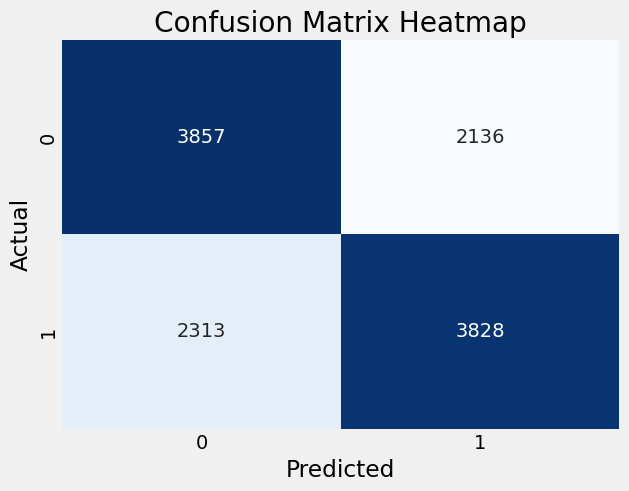

None


In [30]:
evaluation_metrics = evaluate_classifier(LogisticRegression(), X_train, y_train, X_test, y_test)
print(evaluation_metrics)


**Random Forest Classifier**

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.67      0.68      5993
           1       0.68      0.69      0.69      6141

    accuracy                           0.68     12134
   macro avg       0.68      0.68      0.68     12134
weighted avg       0.68      0.68      0.68     12134



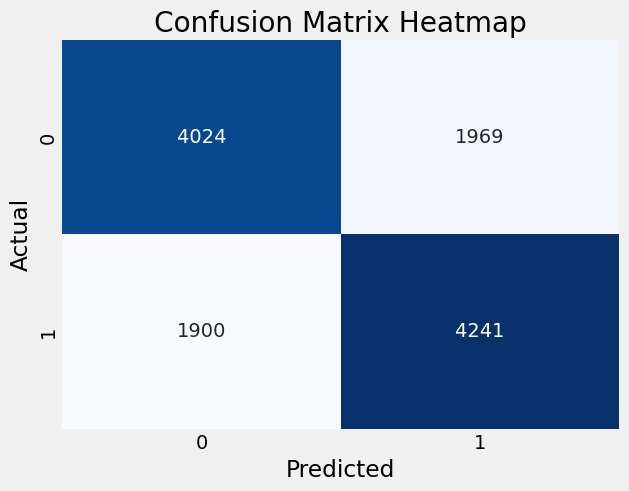

None


In [31]:
evaluation_metrics = evaluate_classifier(RandomForestClassifier(n_estimators= 200, max_depth=30), X_train, y_train, X_test, y_test)
print(evaluation_metrics)

**XGBoost Classifier**

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.64      0.65      5993
           1       0.66      0.68      0.67      6141

    accuracy                           0.66     12134
   macro avg       0.66      0.66      0.66     12134
weighted avg       0.66      0.66      0.66     12134



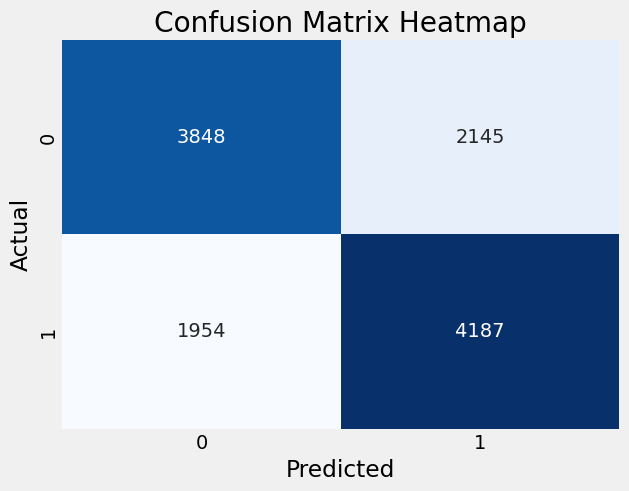

None


In [32]:
evaluation_metrics = evaluate_classifier(XGBClassifier(), X_train, y_train, X_test, y_test)
print(evaluation_metrics)

**Feature Importance**

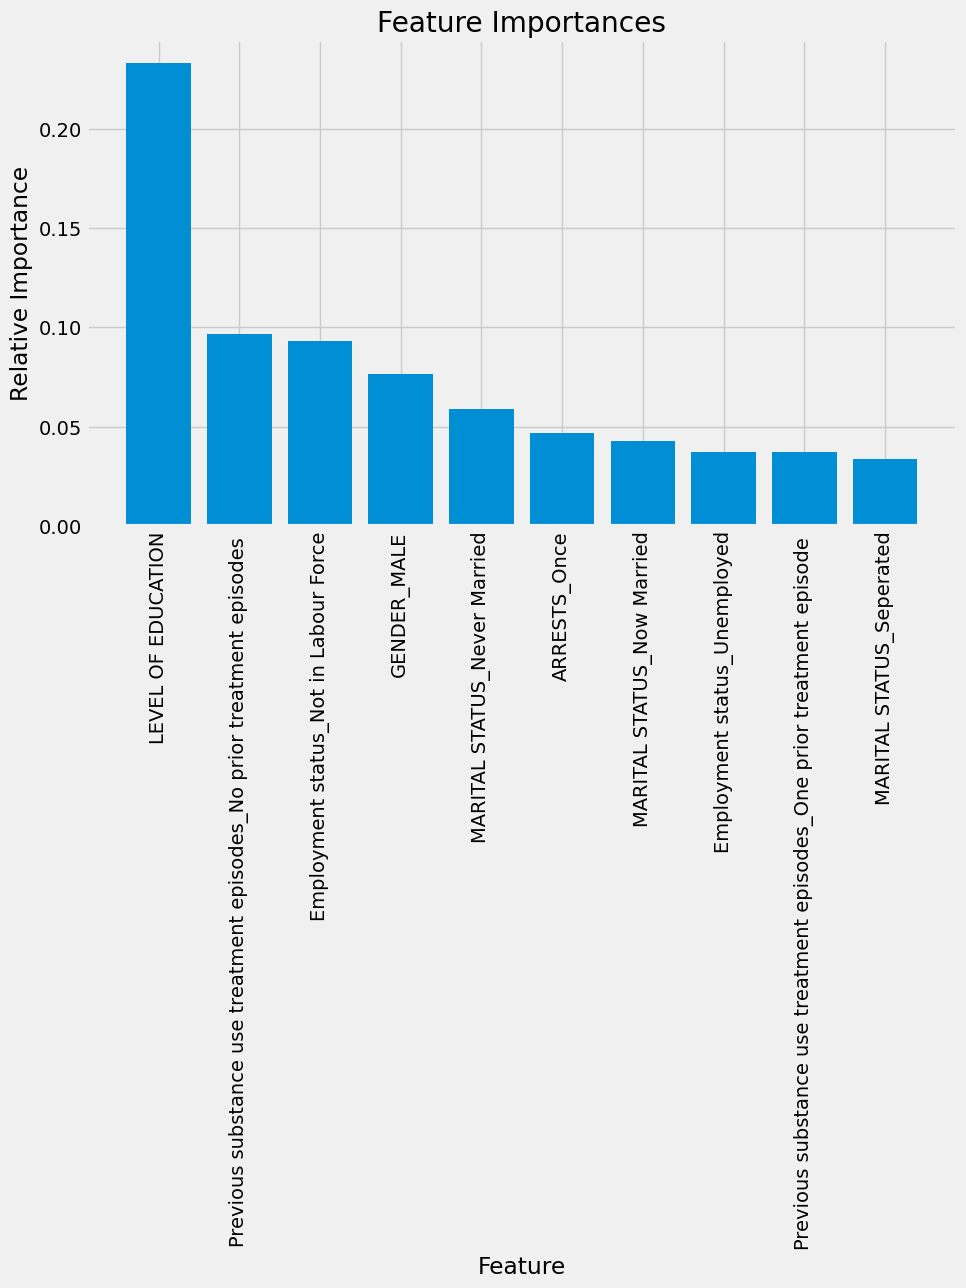

In [33]:
# Creating a Random Forest classifier
model = RandomForestClassifier()

# Fit the model to your data
model.fit(X, y)  
# Get feature importances
importances = model.feature_importances_

# Get feature names (assuming you have stored them in a variable)
feature_names = X.columns

# Sort feature importances in descending order
indices = importances.argsort()[::-1]

# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(10), importances[indices][:10], align="center")
plt.xticks(range(10), [feature_names[i] for i in indices[:10]], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Relative Importance")
plt.show()


**Model Selection and Evaluation Summary:**

After conducting extensive exploratory data analysis (EDA), which included performing Chi-Square tests to assess the relationship between independent variables and the target variable, and addressing the issue of imbalanced data through oversampling with SMOTE, we evaluated several machine learning models for predicting substance abuse.

Logistic Regression yielded an accuracy of 63%

XGBoost Classifier improved the prediction performance with an accuracy of 65%

Random Forest Classifier emerged as the top-performing model, with an f1 score of 67%. This classifier effectively addressed the imbalanced data issue and showcased superior predictive capabilities.

**Evaluation Metrics:**

We assessed model performance using a range of evaluation metrics, including F1-Score, Precision, and Recall. These metrics provided insights into the model's ability to balance precision and recall, especially vital given the class imbalance. Additionally, we employed a Confusion Matrix to visualize true positives, true negatives, false positives, and false negatives.

**Feature Importances:**

The Random Forest Classifier revealed essential insights into feature importance. We found that certain features played a more significant role in predicting substance abuse

The Random Forest Classifier demonstrated the best overall performance, making it our chosen model for predicting substance abuse, achieving an accuracy of 67%. This selection is based on rigorous exploratory data analysis, effective handling of class imbalance, and comprehensive evaluation metrics. 